
#  Introduction

Welcome to the **Employee Performance Rating Prediction** project, built using a rich HR analytics dataset from **Cassandra Systems Inc.** — a leading technology company based in Silicon Valley with over **50,000 employees** across engineering, operations, HR, support, sales, finance, and research divisions.

This dataset provides a detailed view of employee characteristics, including:

- Demographics  
- Experience and project workload  
- Compensation details  
- Education and department  
- Satisfaction metrics  
- Work-life balance  
- Performance rating (target variable)  

Such datasets reflect real-world HR environments where organizations aim to understand and improve employee performance, identify key drivers of productivity, and support fair and data-driven decision-making.

---

## About Dataset

link https://www.kaggle.com/datasets/rockyt07/cassandra-employee-dataset/data

Cassandra Systems Inc. is a leading tech company based in Silicon Valley, California, employing over 50,000 professionals across engineering, operations, HR, sales, and management roles.
This dataset provides a comprehensive look into employee demographics, performance, satisfaction, compensation, and work behavior — making it ideal for real-world HR analytics and machine learning projects.

## Imports

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import warnings
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Optional: CatBoost
!pip install catboost
try:
    from catboost import CatBoostClassifier
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False
    print("CatBoost not installed – skipping it. (pip install catboost if you want it.)")

## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("rockyt07/cassandra-employee-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cassandra-employee-dataset' dataset.
Path to dataset files: /kaggle/input/cassandra-employee-dataset


In [3]:
print(os.listdir(path))

['Employee_Test_Dataset.csv', 'Employee_Train_Dataset.csv', 'Employee_Complete_Dataset.csv', 'Employee_Dataset.sql']


In [4]:
df = pd.read_csv(os.path.join(path,'Employee_Complete_Dataset.csv'))

## Explore The Data


In [5]:
df.head()

,Employee_number,Employee_name,Employee_age,Maritial_Status,Current_Salary,Number_of_Children,years_experience,past_projects,current_projects,Divorced_earlier,Father_alive,Mother_alive,performance_rating,Education_level,Department,Role,Job_Satisfaction,Work_Life_Balance,is_outlier
0,10001,Karen Anderson,36,True,116138,2,12,6,1,No,Yes,Yes,3,Bachelor's,R&D,Researcher,10.000000,1.936454,0
1,10002,David Taylor,34,False,82171,3,10,5,0,Yes,Yes,No,5,Diploma,HR,HR Executive,10.000000,4.077728,0
2,10003,Nina Kumar,36,False,48600,1,0,2,3,Yes,Yes,Yes,4,Diploma,Sales,Sales Manager,10.000000,3.975622,0
3,10004,John Patel,42,True,39675,1,2,4,2,Yes,Yes,Yes,3,Diploma,Engineering,Software Engineer,1.000000,3.790951,0
4,10005,Emily Sharma,27,True,161304,3,3,11,2,Yes,Yes,Yes,2,High School,R&D,Scientist,8.251833,10.000000,0


In [6]:
df.isna().sum().sum()

np.int64(0)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.shape

(50000, 19)

## Preprocessing

In [11]:
df = df.drop(columns=['is_outlier','Employee_number','Employee_name'])

In [9]:
# convert Bools to int. You can use this on anytype of data set if and only if you have bools yes and no
bool_cols = df.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df[col] = df[col].astype(int)

# Also convert 'Yes'/'No' columns to 1/0
yn_cols = ['Divorced_earlier', 'Father_alive', 'Mother_alive']
for col in yn_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

print("Boolean columns converted:\n", df[bool_cols].head())
print("Yes/No columns converted:\n", df[yn_cols].head())

Boolean columns converted:
    Maritial_Status
0                1
1                0
2                0
3                1
4                1
Yes/No columns converted:
    Divorced_earlier  Father_alive  Mother_alive
0                 0             1             1
1                 1             1             0
2                 1             1             1
3                 1             1             1
4                 1             1             1


In [19]:
# OneHotEncoding
cols = ['Education_level','Department','Role']
dummy = pd.get_dummies(df[cols]).astype(int)
df = pd.concat([df,dummy],axis=1)
df = df.drop(cols,axis=1)

i am converting the Job_Satisfaction	Work_Life_Balance to fixed point rather then floating points

In [15]:
# Convert Job Satisfaction (float) → 1–10 integer rating by rounding and clipping
df['Job_Satisfaction'] = df['Job_Satisfaction'].round().clip(lower=1, upper=10).astype(int)

# Convert Work Life Balance (float) → 1–10 integer rating by rounding and clipping
df['Work_Life_Balance'] = df['Work_Life_Balance'].round().clip(lower=1, upper=10).astype(int)

In [20]:
df.head()

,Employee_age,Maritial_Status,Current_Salary,Number_of_Children,years_experience,past_projects,current_projects,Divorced_earlier,Father_alive,Mother_alive,...,Role_HR Manager,Role_ML Engineer,Role_Operations Coordinator,Role_Ops Manager,Role_Researcher,Role_Sales Manager,Role_Scientist,Role_Senior Analyst,Role_Software Engineer,Role_Support Engineer
0,36,1,116138,2,12,6,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
1,34,0,82171,3,10,5,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,36,0,48600,1,0,2,3,1,1,1,...,0,0,0,0,0,1,0,0,0,0
3,42,1,39675,1,2,4,2,1,1,1,...,0,0,0,0,0,0,0,0,1,0
4,27,1,161304,3,3,11,2,1,1,1,...,0,0,0,0,0,0,1,0,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Employee_age                 50000 non-null  int64
 1   Maritial_Status              50000 non-null  int64
 2   Current_Salary               50000 non-null  int64
 3   Number_of_Children           50000 non-null  int64
 4   years_experience             50000 non-null  int64
 5   past_projects                50000 non-null  int64
 6   current_projects             50000 non-null  int64
 7   Divorced_earlier             50000 non-null  int64
 8   Father_alive                 50000 non-null  int64
 9   Mother_alive                 50000 non-null  int64
 10  performance_rating           50000 non-null  int64
 11  Job_Satisfaction             50000 non-null  int64
 12  Work_Life_Balance            50000 non-null  int64
 13  Education_level_Bachelor's   50000 non-null  i

In [22]:
df.isna().sum().sum()

np.int64(0)

## Visualization

### Plot Histograms of Key Numerical Features


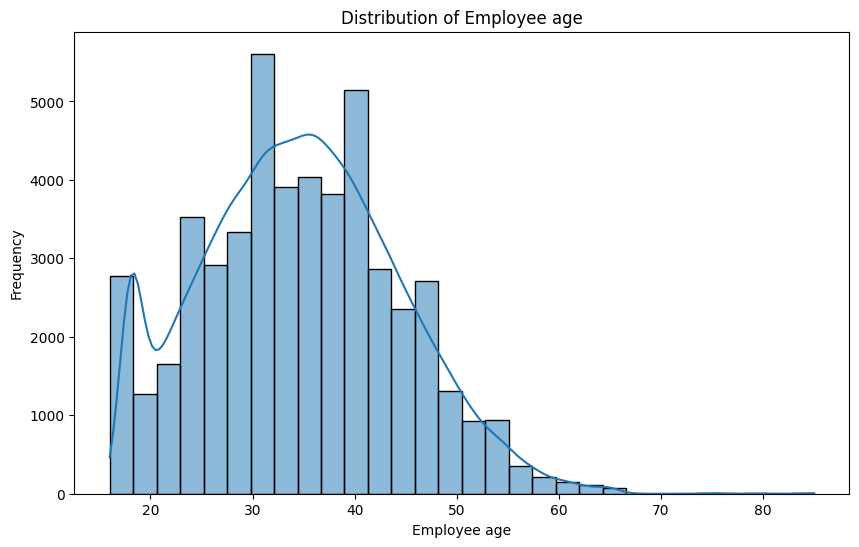

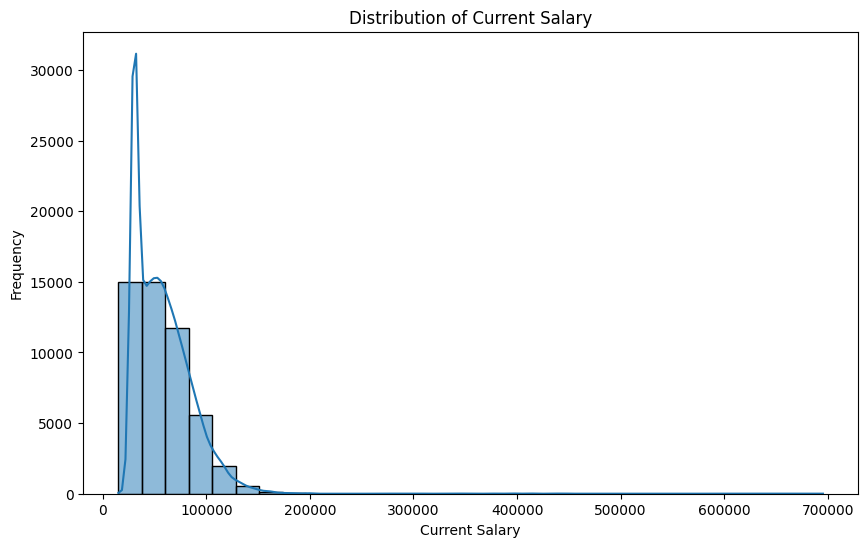

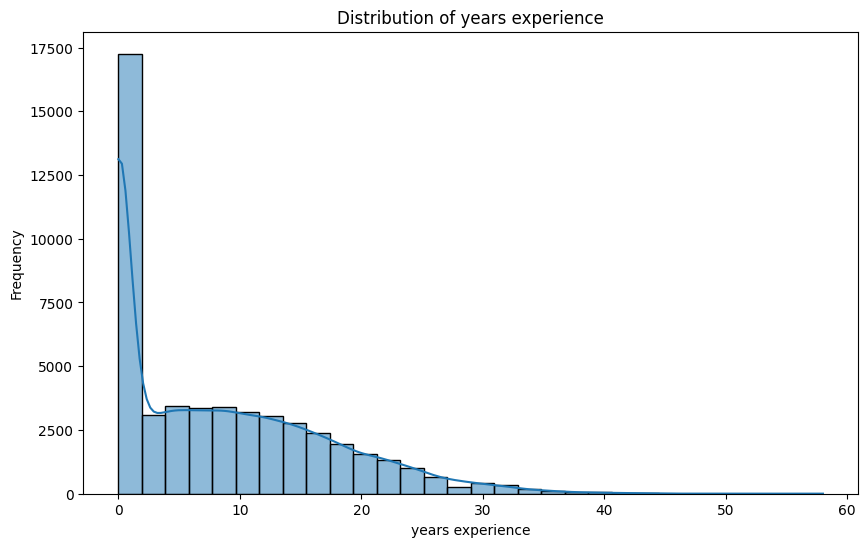

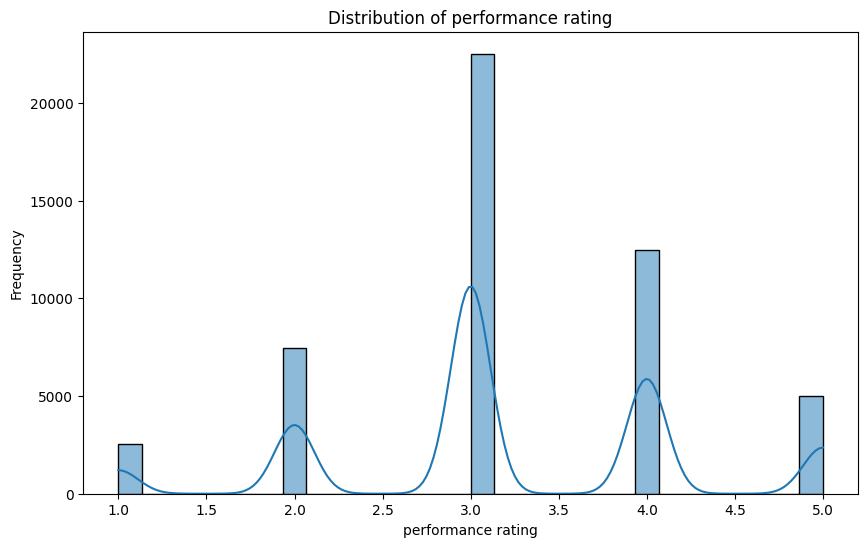

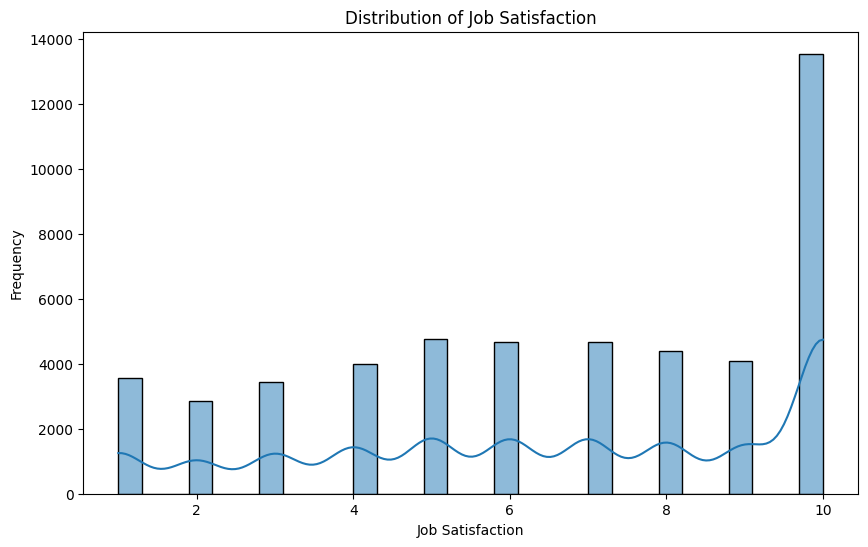

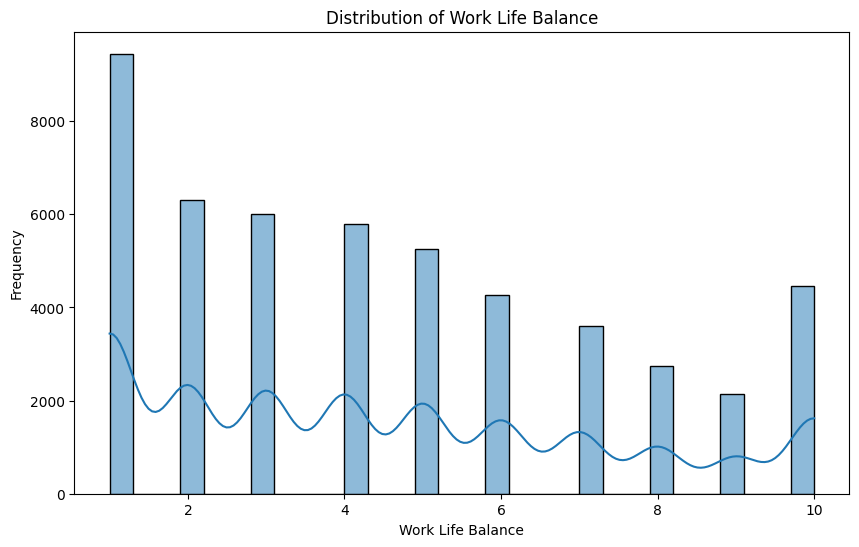

In [23]:
numerical_cols = ['Employee_age', 'Current_Salary', 'years_experience', 'performance_rating', 'Job_Satisfaction', 'Work_Life_Balance']

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col.replace("_", " ")}')
    plt.xlabel(col.replace("_", " "))
    plt.ylabel('Frequency')
    plt.show()

### Plot Box Plot of Current Salary by Performance Rating


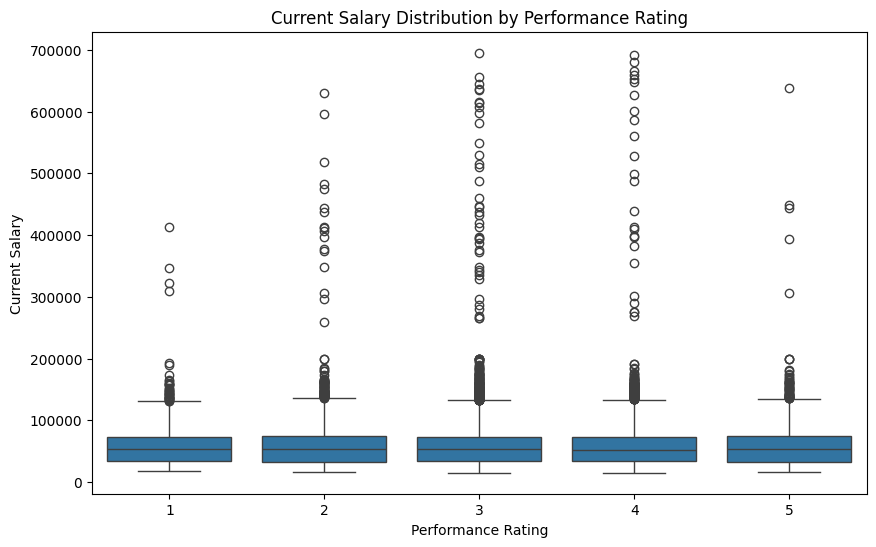

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='performance_rating', y='Current_Salary', data=df)
plt.title('Current Salary Distribution by Performance Rating')
plt.xlabel('Performance Rating')
plt.ylabel('Current Salary')
plt.show()

### Plot Correlation Heatmap of Numerical Features



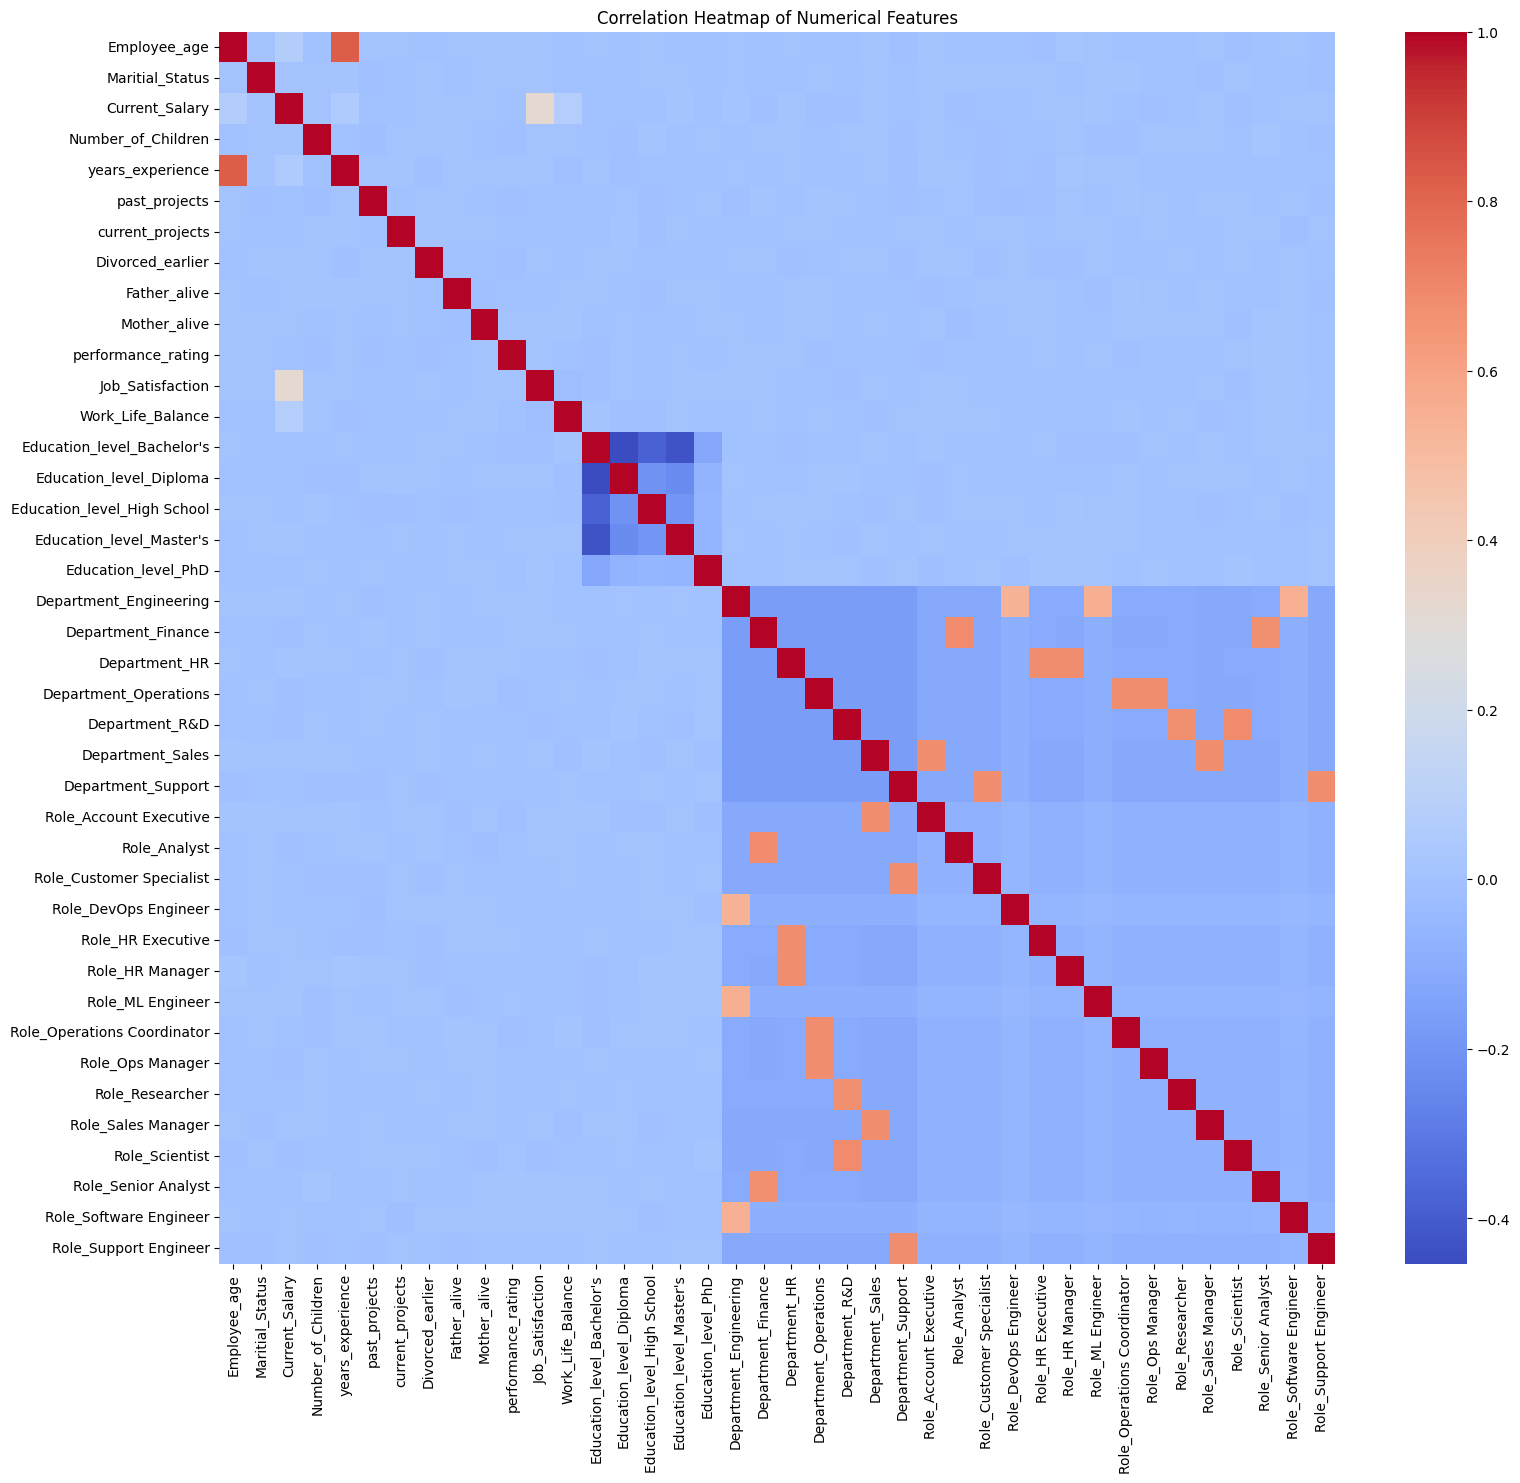

In [25]:
plt.figure(figsize=(18, 16)) # Increased size for better readability given the number of columns
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', fmt=".2f") # annot=False to prevent overcrowding
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Identify Numerical Columns for Outlier Detection


In [26]:
numerical_cols_for_outliers = ['Employee_age', 'Current_Salary', 'years_experience', 'performance_rating', 'Job_Satisfaction', 'Work_Life_Balance']
print("Numerical columns selected for outlier analysis:", numerical_cols_for_outliers)

Numerical columns selected for outlier analysis: ['Employee_age', 'Current_Salary', 'years_experience', 'performance_rating', 'Job_Satisfaction', 'Work_Life_Balance']


In [27]:
outlier_summary = {}

for col in numerical_cols_for_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    outlier_summary[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'num_outliers': len(outliers),
        '%_outliers': (len(outliers) / len(df)) * 100
    }

# Print the summary for each column
for col, data in outlier_summary.items():
    print(f"\n--- {col.replace('_', ' ').title()} ---")
    for key, value in data.items():
        print(f"{key.replace('_', ' ').title()}: {value:.2f}")



--- Employee Age ---
Q1: 28.00
Q3: 41.00
Iqr: 13.00
Lower Bound: 8.50
Upper Bound: 60.50
Num Outliers: 271.00
% Outliers: 0.54

--- Current Salary ---
Q1: 33581.00
Q3: 73750.00
Iqr: 40169.00
Lower Bound: -26672.50
Upper Bound: 134003.50
Num Outliers: 636.00
% Outliers: 1.27

--- Years Experience ---
Q1: 0.00
Q3: 14.00
Iqr: 14.00
Lower Bound: -21.00
Upper Bound: 35.00
Num Outliers: 231.00
% Outliers: 0.46

--- Performance Rating ---
Q1: 3.00
Q3: 4.00
Iqr: 1.00
Lower Bound: 1.50
Upper Bound: 5.50
Num Outliers: 2553.00
% Outliers: 5.11

--- Job Satisfaction ---
Q1: 4.00
Q3: 10.00
Iqr: 6.00
Lower Bound: -5.00
Upper Bound: 19.00
Num Outliers: 0.00
% Outliers: 0.00

--- Work Life Balance ---
Q1: 2.00
Q3: 7.00
Iqr: 5.00
Lower Bound: -5.50
Upper Bound: 14.50
Num Outliers: 0.00
% Outliers: 0.00


### Visualize Outliers with Box Plots

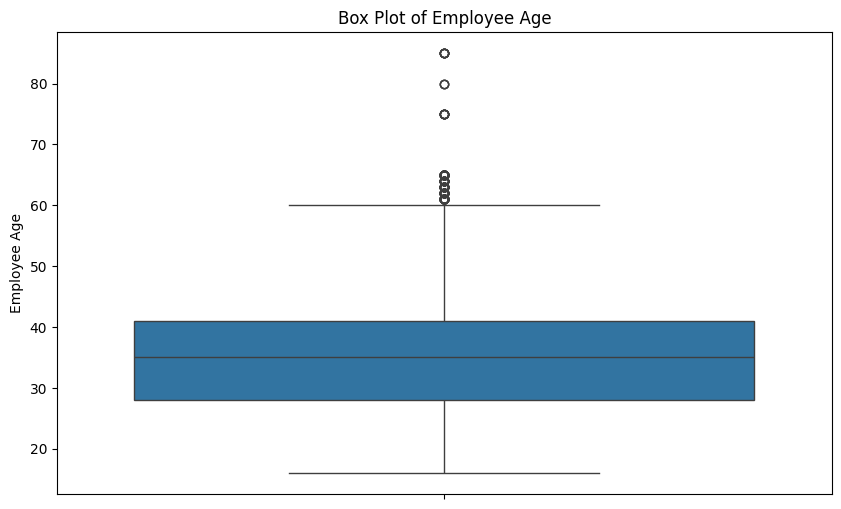

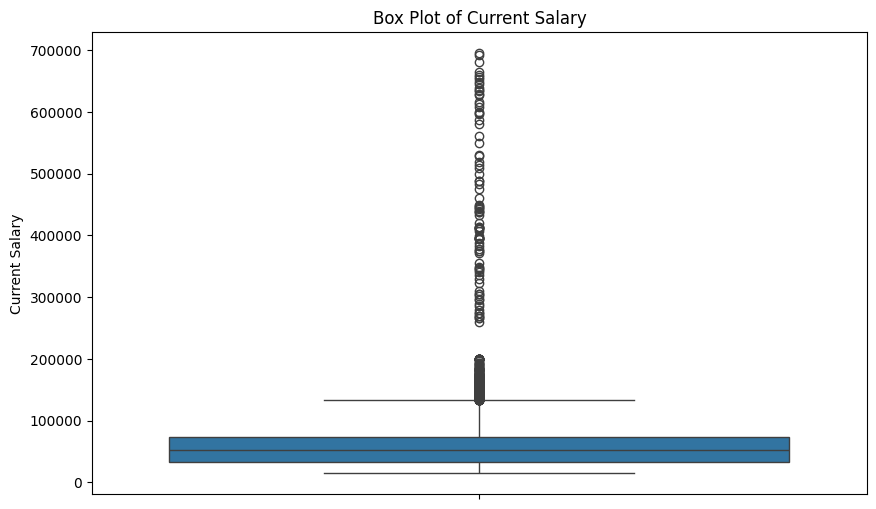

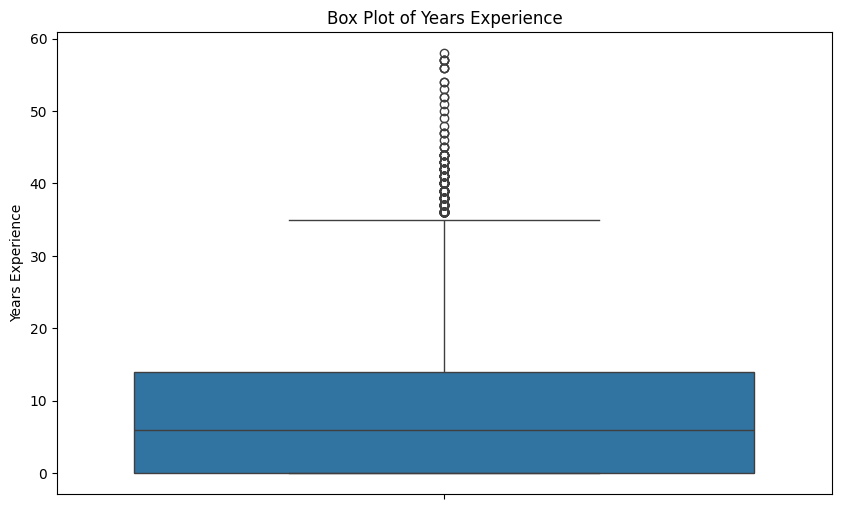

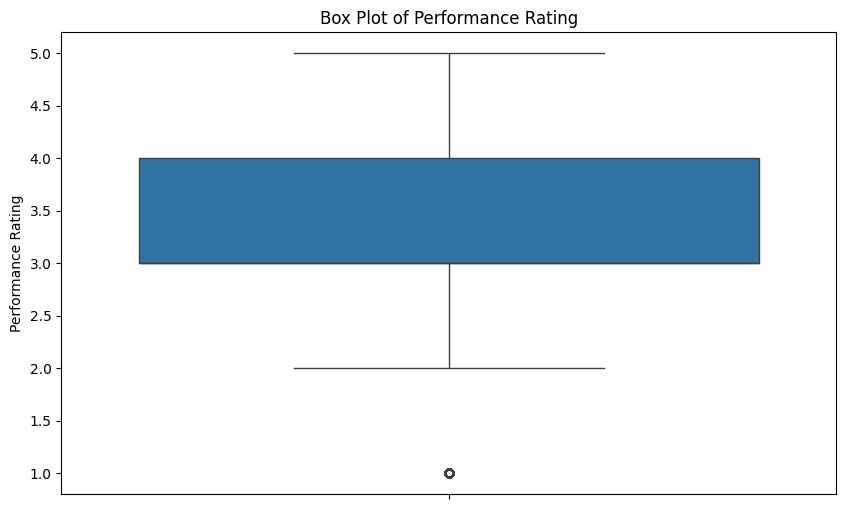

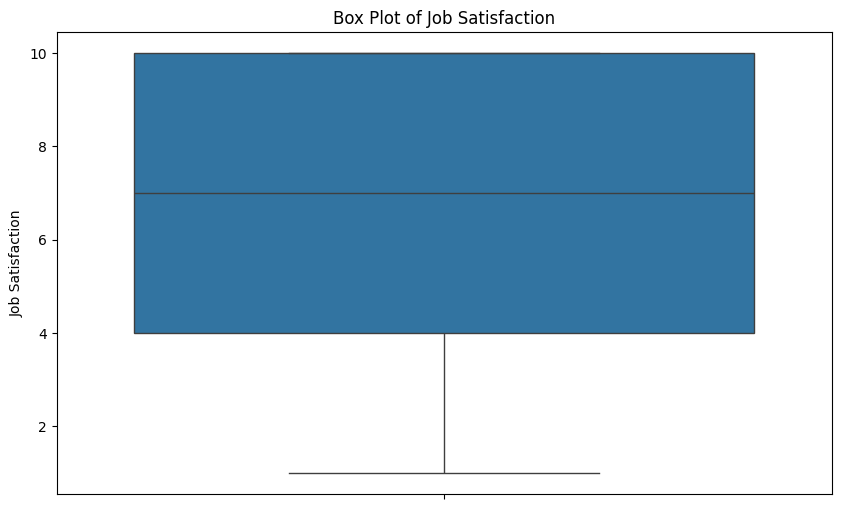

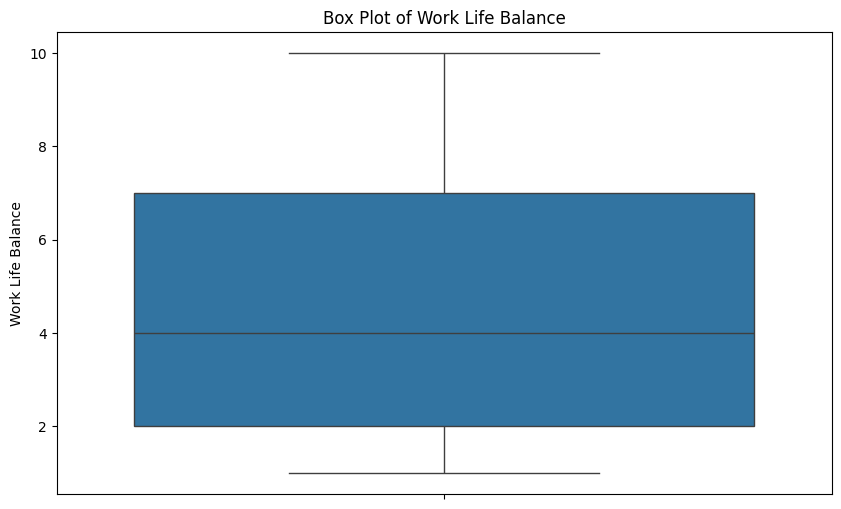

In [28]:
for col in numerical_cols_for_outliers:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col.replace("_", " ").title()}')
    plt.ylabel(col.replace("_", " ").title())
    plt.show()

### Summary:

### Q&A
The outlier detection process involved:
1.  **Identifying Numerical Columns**: Six numerical columns were selected for analysis: 'Employee\_age', 'Current\_Salary', 'years\_experience', 'performance\_rating', 'Job\_Satisfaction', and 'Work\_Life\_Balance'.
2.  **Outlier Quantification (IQR Method)**: For each column, the Interquartile Range (IQR) method was applied. This involved calculating the first quartile (Q1), third quartile (Q3), and IQR (Q3 - Q1). Outliers were defined as data points falling below `Q1 - 1.5 * IQR` or above `Q3 + 1.5 * IQR`.
3.  **Visualization**: Box plots were generated for each column to visually represent the data distribution and clearly mark the identified outliers.

The number of outliers found in each numerical column were:
*   **Employee\_age**: 271 outliers (0.54%)
*   **Current\_Salary**: 636 outliers (1.27%)
*   **years\_experience**: 231 outliers (0.46%)
*   **performance\_rating**: 2553 outliers (5.11%)
*   **Job\_Satisfaction**: 0 outliers (0.00%)
*   **Work\_Life\_Balance**: 0 outliers (0.00%)

Implications for further analysis or modeling:
The presence of outliers, particularly in 'performance\_rating' (5.11%), 'Current\_Salary' (1.27%), and 'Employee\_age' (0.54%), suggests that these columns contain extreme values that could skew statistical analyses or affect the performance of machine learning models. For instance, very high or low performance ratings might represent exceptional cases that need special handling or investigation. Similarly, extreme salaries could indicate executive-level positions or data entry errors. 'Job\_Satisfaction' and 'Work\_Life\_Balance' appear to have well-distributed data without significant outliers, indicating more consistent responses in these areas. Depending on the downstream task, these outliers may need to be treated (e.g., removed, transformed, or capped) to ensure robust model performance and accurate insights.

### Data Analysis Key Findings
*   Outliers were detected in four of the six analyzed numerical columns using the IQR method.
*   'performance\_rating' showed the highest percentage of outliers, with 2553 instances, constituting 5.11% of the data.
*   'Current\_Salary' had a notable presence of outliers, with 636 instances, representing 1.27% of the data.
*   'Employee\_age' and 'years\_experience' also contained outliers, with 271 (0.54%) and 231 (0.46%) instances, respectively.
*   No outliers were detected in 'Job\_Satisfaction' or 'Work\_Life\_Balance' columns.

### Insights or Next Steps
*   The significant number of outliers in 'performance\_rating' and 'Current\_Salary' indicates that these variables may contain valuable information about exceptional employees or specific compensation structures, warranting further investigation into their nature (e.g., data errors vs. legitimate extreme values).
*   For subsequent modeling or statistical analysis, consider implementing outlier treatment strategies such as Winsorization, robust scaling, or removal for the columns identified with outliers to prevent potential bias or impact on model performance.


## Train Test Split

In [29]:
y = df["Job_Satisfaction"]
X = df.drop("Job_Satisfaction", axis=1)


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,train_size=0.75)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37500, 39), (12500, 39), (37500,), (12500,))

## Feature Scaling + Model Training

In [30]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
from collections import Counter

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("\nOriginal classes:", le.classes_)
print("Encoded classes :", np.unique(y_train_enc))

print("\nClass distribution in y_train:")
print(Counter(y_train_enc))


Original classes: [ 1  2  3  4  5  6  7  8  9 10]
Encoded classes : [0 1 2 3 4 5 6 7 8 9]

Class distribution in y_train:
Counter({np.int64(9): 10072, np.int64(4): 3615, np.int64(5): 3540, np.int64(6): 3495, np.int64(7): 3329, np.int64(8): 3027, np.int64(3): 3014, np.int64(0): 2691, np.int64(2): 2620, np.int64(1): 2097})


##  Define Models

In [37]:
models = []

models.append((
    "RandomForest",
    RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
))

models.append((
    "GradientBoosting",
    GradientBoostingClassifier(
        random_state=42
    )
))

models.append((
    "XGBoost",
    XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=len(le.classes_),
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42
    )
))

models.append((
    "LightGBM",
    LGBMClassifier(
        n_estimators=300,
        learning_rate=0.08,
        objective="multiclass",
        num_class=len(le.classes_),
        random_state=42,
        n_jobs=-1
    )
))

results = []
best_model_name = None
best_f1 = -1
best_pipe = None
best_pred_enc = None


## Summary table

In [38]:
for name, estimator in models:
    pipe = Pipeline([
        ("model", estimator)
    ])

    pipe.fit(X_train, y_train_enc)
    y_pred_enc = pipe.predict(X_test)

    acc = accuracy_score(y_test_enc, y_pred_enc)
    f1_macro = f1_score(y_test_enc, y_pred_enc, average="macro")

    print(f"Accuracy : {acc:.4f}")
    print(f"F1-macro: {f1_macro:.4f}")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1_macro": f1_macro
    })

    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_model_name = name
        best_pipe = pipe
        best_pred_enc = y_pred_enc

# Summary table
results_df = pd.DataFrame(results).sort_values(
    by="F1_macro", ascending=False
).reset_index(drop=True)

print("\n\nModel Performance Comparison:")
display(results_df)

print(f"\nBest model based on F1-macro: {best_model_name}")


Training: RandomForest
Accuracy : 0.2719
F1-macro: 0.1037

Training: GradientBoosting
Accuracy : 0.2894
F1-macro: 0.0905

Training: XGBoost
Accuracy : 0.2717
F1-macro: 0.1142

Training: LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 37500, number of used features: 39
[LightGBM] [Info] Start training from score -2.634428
[LightGBM] [Info] Start training from score -2.883833
[LightGBM] [Info] Start training from score -2.661167
[LightGBM] [Info] Start training from score -2.521073
[LightGBM] [Info] Start training from score -2.339249
[LightGBM] [Info] Start training from score -2.360214
[LightGBM] [Info] Start training from score -2.3

,Model,Accuracy,F1_macro
0,XGBoost,0.27168,0.114234
1,LightGBM,0.26960,0.112806
2,RandomForest,0.27192,0.103668
3,GradientBoosting,0.28936,0.090530



Best model based on F1-macro: XGBoost


## Classification Report for Best Model (with original 1–10 labels)

Classification Report for best model: XGBoost

              precision    recall  f1-score   support

           1       0.19      0.32      0.24       888
           2       0.13      0.09      0.10       714
           3       0.12      0.05      0.08       861
           4       0.11      0.05      0.07       998
           5       0.13      0.06      0.08      1189
           6       0.11      0.04      0.06      1169
           7       0.09      0.02      0.03      1172
           8       0.10      0.02      0.03      1099
           9       0.09      0.01      0.02      1022
          10       0.34      0.83      0.48      3388

    accuracy                           0.27     12500
   macro avg       0.14      0.15      0.12     12500
weighted avg       0.18      0.27      0.18     12500



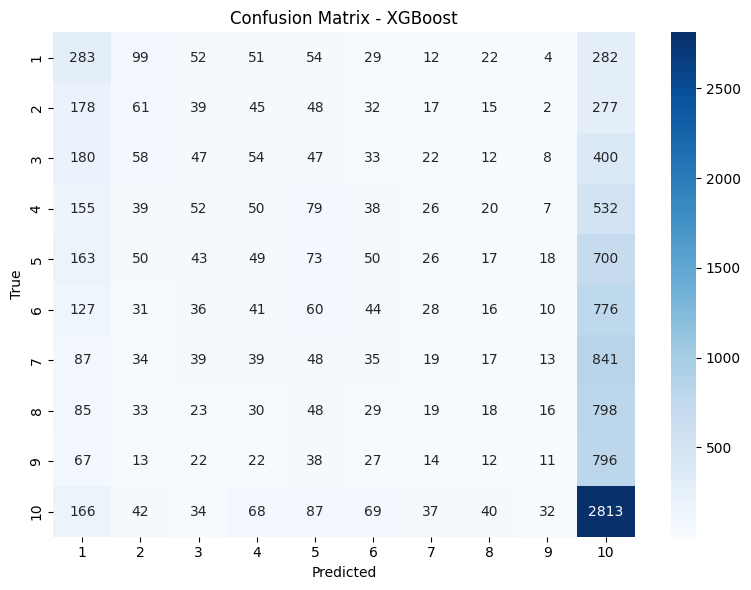

In [8]:
y_test_orig = le.inverse_transform(y_test_enc)
y_pred_orig = le.inverse_transform(best_pred_enc)

print(f"Classification Report for best model: {best_model_name}\n")
print(classification_report(y_test_orig, y_pred_orig))

# Confusion Matrix
cm = confusion_matrix(y_test_orig, y_pred_orig)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=sorted(le.classes_),
    yticklabels=sorted(le.classes_)
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

## Conclusion

In this project, we explored whether it is possible to build a machine-learning model to predict Employee Job Satisfaction using demographic, compensation, and work-related features. Although we applied extensive preprocessing and trained multiple models (RandomForest, GradientBoosting, XGBoost, LightGBM), the overall predictive performance remained limited.

## Key Findings

The models were able to identify extreme satisfaction levels (1 and 10) reasonably well.

However, mid-range satisfaction levels (4–7) showed significant overlap, leading to high misclassification.

Most input features demonstrated very weak correlations with Job Satisfaction (close to zero).

Even after transforming satisfaction and work-life balance into 1–10 ratings, the dataset still lacked strong predictive signal.

The confusion matrix confirmed that the model often predicts adjacent classes, indicating uncertainty and limited separability in the feature space.

## Why Prediction Fails

The dataset appears to contain weak or synthetic relationships, making it unsuitable for high-accuracy prediction. Important real-world HR factors—such as employee engagement, team culture, manager feedback, promotion history, workload intensity, and organizational climate—are missing. Without these, the predictive model cannot learn meaningful boundaries.

## What This Dataset Is Good For

While predictive modeling is limited, the dataset is excellent for:

Exploratory Data Analysis (EDA)

Visualizing employee demographics

Understanding salary and experience distributions

Demonstrating categorical encoding

Practicing end-to-end ML workflows

Learning model comparison, evaluation, and confusion matrix interpretation

## Final Assessment
This dataset is useful for EDA and machine learning practice,
but it does not contain enough meaningful signal to build a
high-accuracy Job Satisfaction prediction model.